In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import os
from pathlib import Path
import json 
import logging
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.INFO)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.INFO)

from sklearn.semi_supervised import LabelPropagation, LabelSpreading

#General ML 
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, silhouette_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from modules.clustering_helpers import select_labeled_samples
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Active Learning
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling


#In-house Module Imports
from config import Configuration 
from datasets import EclipseSampledDataset, VoltaSampledDataset
from utils import *

def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]


def call_FAR_function(false_alarm_rates,anomaly_miss_rates, test_label, y_pred, conf):
    false_alarm_rate, anom_miss_rate = FAR_AMR_Calculate(
            true_label= test_label['anom'].to_numpy(),
            pred_label= y_pred,
            result_dir= str(conf['results_dir']),
            save_name= "",
            save=False,
            verbose=False,
    )
    false_alarm_rates.append(false_alarm_rate)
    anomaly_miss_rates.append(anom_miss_rate)

query_strategy_dict = {
                       "uncertainty": uncertainty_sampling, 
                       "margin": margin_sampling, 
                       "entropy": entropy_sampling,
                       "random": random_sampling
                      }

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from collections import defaultdict
from matplotlib.colors import rgb2hex, colorConverter
from scipy.cluster.hierarchy import set_link_color_palette
import scipy.cluster.hierarchy as sch

In [5]:
user = "aksar"
logging.warning(f'Are you sure that you are: {user}?')

2022-04-11 12:43:09,433 WARNING Are you sure that you are: aksar?


In [6]:
MODEL_CONFIG = "implementation_exp_1_active_learning"  # change this
#num_knowns_in_training = 2
SYSTEM = 'volta'  # volta or eclipse
FE_NAME = 'tsfresh' #tsfresh, or mvts => It will set the EXP_NAME. Be careful. 
NUM_FEATURE = 250  # example: 250 ,2000, 4000
classifier_name = 'rf'
query_strategy = "random"  # "uncertainty", "margin", "entropy", "random"
CV_INDEX = 0  # it can be integer value within the range 0 1 2 3 4
repeat_num = 0
query_size = 50

In [7]:
#Constants
FS_NAME = "CHI"
method = "random" if query_strategy == 'random' else "active_learning"
num_samples_per_pair = 1
OUTPUT_DIR = f'/projectnb/peaclab-mon/{user}/active_learning_experiments'
EXP_NAME = f'{FE_NAME}_experiments'
FEATURE_SELECTION = False
SCALER = 'None' #For now, do the scaling inside the notebook, then you can move that to the class function

logging.warning('Results will be generated in {}, double check please!'.format(MODEL_CONFIG))

2022-04-11 12:43:17,820 WARNING Results will be generated in implementation_exp_1_active_learning, double check please!


In [8]:
conf = Configuration(ipython=True,
                     overrides={
                         'output_dir': Path(OUTPUT_DIR), #change
                         'system' : SYSTEM,
                         'exp_name':EXP_NAME,                                                  
                         'cv_fold':CV_INDEX, 
                         'model_config': MODEL_CONFIG,
                     })

with open(str(conf['experiment_dir']) + '/anom_dict.json') as f:
    ANOM_DICT = json.load(f)
with open(str(conf['experiment_dir']) + '/app_dict.json') as f:
    APP_DICT = json.load(f) 
    
APP_REVERSE_DICT = {}
for app_name, app_encoding in APP_DICT.items():
    APP_REVERSE_DICT[app_encoding] = app_name    

ANOM_REVERSE_DICT = {}
for anom_name, anom_encoding in ANOM_DICT.items():
    ANOM_REVERSE_DICT[anom_encoding] = anom_name

2022-04-11 12:43:19,148 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2022-04-11 12:43:19,149 INFO    Setting directory names
2022-04-11 12:43:19,154 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2022-04-11 12:43:19,157 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 0,
#  'exp_name': 'tsfresh_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/tpds_data_hdfs'),
#  'metadata_path': None,
#  'model_config': 'implementation_exp_1_active_learning',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/implementation_exp_1_active_learning'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/implementation_exp_1_active_learning/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_e

In [9]:
if SYSTEM == 'eclipse':
    eclipseDataset = EclipseSampledDataset(conf)
    train_data, train_label, test_data, test_label = eclipseDataset.load_dataset(scaler=SCALER,
                                                                                 cv_fold=CV_INDEX,
                                                                                 borghesi=False, 
                                                                                 mvts=True if FE_NAME == 'mvts' else False, 
                                                                                 tsfresh=True if FE_NAME == 'tsfresh' else False)

elif SYSTEM == 'volta':
    voltaDataset = VoltaSampledDataset(conf)
    train_data, train_label, test_data, test_label = voltaDataset.load_dataset(scaler=SCALER,
                                                                               cv_fold=CV_INDEX,
                                                                               borghesi=False,
                                                                               mvts=True if FE_NAME == 'mvts' else False,
                                                                               tsfresh=True if FE_NAME == 'tsfresh' else False)

assert list(train_data.index) == list(train_label.index) #check the order of the labels     
assert list(test_data.index) == list(test_label.index) #check the order of the labels    

if FEATURE_SELECTION:
    selected_features = pd.read_csv(conf['experiment_dir'] / 'selected_features.csv')
    train_data = train_data[list(selected_features['0'].values)]
    test_data = test_data[list(selected_features['0'].values)]
    
train_label['anom_names'] = train_label.apply(lambda x: ANOM_REVERSE_DICT[x['anom']], axis=1)
train_label['app_names']=train_label['app'].apply(lambda x: APP_REVERSE_DICT[x])
test_label['anom_names'] = test_label.apply(lambda x: ANOM_REVERSE_DICT[x['anom']], axis=1)
test_label['app_names']=test_label['app'].apply(lambda x: APP_REVERSE_DICT[x])

all_data = pd.concat([train_data, test_data])
all_data = all_data.dropna(axis=1, how='any')
all_label = pd.concat([train_label,test_label])

train_data = all_data.loc[train_label.index]
test_data = all_data.loc[test_label.index]
    
logging.info("Train data shape %s",train_data.shape)
logging.info("Train label shape %s",train_label.shape)
logging.info("Test data shape %s",test_data.shape)  
logging.info("Test label shape %s",test_label.shape)

logging.info("Train data label dist: \n%s",train_label['anom'].value_counts())
logging.info("Test data label dist: \n%s",test_label['anom'].value_counts())  

2022-04-11 12:43:21,197 INFO    BaseDataset Class Initialization
2022-04-11 12:43:21,198 INFO    HPCDataset Class Initialization
2022-04-11 12:43:21,198 INFO    VoltaSampledDataset Class Initialization
2022-04-11 12:43:21,298 INFO    Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-04-11 12:44:50,041 INFO    Train data shape (6326, 102311)
2022-04-11 12:44:50,046 INFO    Train label shape (6326, 2)
2022-04-11 12:44:50,047 INFO    Test data shape (14589, 102311)
2022-04-11 12:44:50,047 INFO    Test label shape (14589, 2)
2022-04-11 12:44:50,049 WARNING Beware that no scaling method is applied
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'

In [10]:
SCALER = 'MinMax'

if SCALER == 'MinMax':
    
    minmax_scaler = MinMaxScaler().fit(train_data)
    train_data = pd.DataFrame(minmax_scaler.transform(train_data),columns=train_data.columns,index=train_data.index)
    test_data = pd.DataFrame(minmax_scaler.transform(test_data),columns=test_data.columns,index=test_data.index)
    
elif SCALER == 'Standard':
    
    # Standardize data (per feature Z-normalization, i.e. zero-mean and unit variance)        
    scaler = StandardScaler().fit(train_data)
    train_data = pd.DataFrame(scaler.transform(train_data),columns=train_data.columns,index=train_data.index)
    test_data = pd.DataFrame(scaler.transform(test_data),columns=test_data.columns,index=test_data.index)  
    
#Implement new feature selection strategies below
if FS_NAME == 'CHI':
    
    selector = SelectKBest(chi2, k=NUM_FEATURE)
    selector.fit(train_data,train_label['anom'])
    train_data = train_data[train_data.columns[selector.get_support(indices=True)]]
    selected_columns = train_data.columns
    test_data = test_data[test_data.columns & selected_columns]
    
elif FS_NAME == 'TSFRESH':
    logging.warning("NUM_FEATURE parameter will be overwritten by the automatic selection process")
    
    y_train = train_label['anom']
    X_train = train_data

    relevant_features = set()

    for label in y_train.unique():
        y_train_binary = y_train == label
        X_train_filtered = tsfresh.select_features(X_train, y_train_binary)
        print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
        relevant_features = relevant_features.union(set(X_train_filtered.columns))    
    train_data = train_data[relevant_features]
    test_data = test_data[relevant_features]
    NUM_FEATURE = len(relevant_features)
    
elif FS_NAME == 'NONE':
    logging.info("No feature selection strategy is specified, will be using all features")
    NUM_FEATURE = len(train_data.columns)
    
logging.info(train_data.shape)
logging.info(test_data.shape)

2022-04-11 12:46:02,566 INFO    (6326, 250)
2022-04-11 12:46:02,568 INFO    (14589, 250)


In [11]:
scaled_all_normal_data = pd.concat([train_data,test_data]).loc[all_label[all_label['anom'] == 0].index]
healthy_labels = all_label[all_label['anom'] == 0]

In [12]:
scaled_all_normal_data['app_names'] = healthy_labels['app_names']
#scaled_all_normal_data['app'] = healthy_labels['app']"""
scaled_all_normal_data.set_index("app_names", inplace=True)

In [13]:
app_names = healthy_labels['app_names'].unique()

In [14]:
clustdf = scaled_all_normal_data

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [65.0, 65.0, 75.0, 75.0],
  [85.0, 85.0, 95.0, 95.0],
  [115.0, 115.0, 125.0, 125.0],
  [145.0, 145.0, 155.0, 155.0],
  [165.0, 165.0, 175.0, 175.0],
  [150.0, 150.0, 170.0, 170.0],
  [135.0, 135.0, 160.0, 160.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [195.0, 195.0, 212.5, 212.5],
  [185.0, 185.0, 203.75, 203.75],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [255.0, 255.0, 272.5, 272.5],
  [245.0, 245.0, 263.75, 263.75],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [365.0, 365.0, 375.0, 375.0],
  [355.0, 355.0, 370.0, 370.0],
  [345.0, 345.0, 362.5, 362.5],
  [385.0, 385.0, 395.0, 395.0],
  [353.75, 353.75, 390.0, 390.0],
  [335.0, 335.0, 371.875, 371.875],
  [325.0, 325.0, 353.4375, 353.4375],
  [302.5, 302.5, 339.21875, 339.21875],
  [254.375, 254.375, 320.859375, 320.859375],
  [235.0, 235.0, 287.6171875, 287.6171875],
  

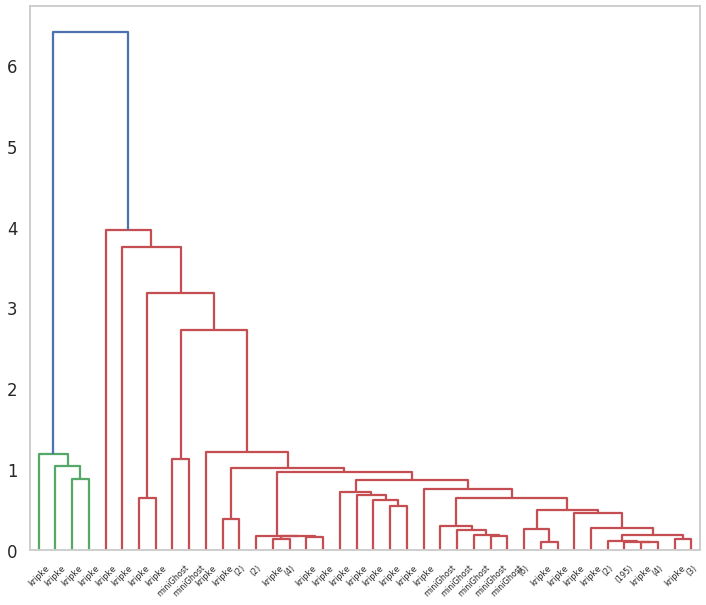

In [49]:
clustdf_t = scaled_all_normal_data.transpose()
c_dist = pdist(clustdf_t) # computing the distance
c_link = linkage(c_dist)# computing the linkage
dendrogram(c_link, truncate_mode='lastp',p = 40,labels=clustdf.index)

In [76]:
"""X = scaled_all_normal_data.iloc[:,:-2].T.values #Transpose values 
Y = pdist(X)
Z = linkage(Y)
dendrogram(Z, labels = scaled_all_normal_data['app_names'])"""

"X = scaled_all_normal_data.iloc[:,:-2].T.values #Transpose values \nY = pdist(X)\nZ = linkage(Y)\ndendrogram(Z, labels = scaled_all_normal_data['app_names'])"

In [16]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

In [17]:
def get_clust_graph(df, numclust, transpose=False, dataname="all", save=False, xticksize=8):
    if transpose==True:
        aml=df.transpose()
        xl="x-axis"
    else:
        aml=df
        xl="y-axis"
    data_dist = pdist(aml.transpose()) # computing the distance
    data_link = linkage(data_dist)#method="complete") # computing the linkage
    B=dendrogram(data_link,labels=list(aml.columns),p=numclust, truncate_mode="lastp",get_leaves=True, count_sort='ascending', show_contracted=True)
    #myInd = [i for i, c in zip(B['ivl'], B['color_list']) if c=='g']
    get_cluster_classes(B)
    ax=plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=xticksize)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.xlabel(xl)
    #plt.set_size_inches(18.5, 10.5)
    plt.ylabel('Distance')
    plt.suptitle(xl+" clustering for "+dataname, fontweight='bold', fontsize=16);
    if save:
        plt.savefig(str(df.index.name)+str(numclust)+"tr_"+str(transpose)+"dn_"+str(dataname)+save+'.png')
    else:
        print("Not saving")
    return get_cluster_classes(B)

In [18]:
def give_cluster_assigns(df, numclust, tranpose=True):
    if transpose==True:
        data_dist = pdist(df.transpose())
        data_link = linkage(data_dist,  metric='correlation', method='complete')
        cluster_assigns=pd.Series(sch.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.columns)
    else:
        data_dist = pdist(df)
        data_link = linkage(data_dist,  metric='correlation', method='complete')
        cluster_assigns=pd.Series(sch.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.index)
    for i in arange(1,numclust+1):
        print("Cluster ",str(i),": ( N =",len(cluster_assigns[cluster_assigns==i].index),")", ", ".join(list(cluster_assigns[cluster_assigns==i].index)))

In [18]:
get_clust_graph(clustdf, 193, transpose=True)

2022-04-11 12:49:11,748 ERROR   Internal Python error in the inspect module.
Below is the traceback from this internal error.

2022-04-11 12:49:11,848 INFO    
Unfortunately, your original traceback can not be constructed.

2022-04-11 12:49:11,926 ERROR   Internal Python error in the inspect module.
Below is the traceback from this internal error.

2022-04-11 12:49:11,931 INFO    
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-22ba819ea546>", line 1, in <module>
    get_clust_graph(clustdf, 193, transpose=True)
  File "<ipython-input-17-7bb561efe1d2>", line 9, in get_clust_graph
    data_link = linkage(data_dist)#method="complete") # computing the linkage
  File "/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/scipy/cluster/hierarchy.py", line 1068, in linkage
    result = _hierarchy.mst_single_linkage(y, n)
  File "_hierarchy.pyx", line 1067, in scipy.cluster._hierarchy.mst_single_linkage
  File "<__array_function__ internals>", line 2, in argsort
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/IPython/c

TypeError: object of type 'NoneType' has no len()

values passed to leaf_label_func
leaves :  [480, 484, 217, 218, 476, 483, 481, 472, 488, 470, 487]


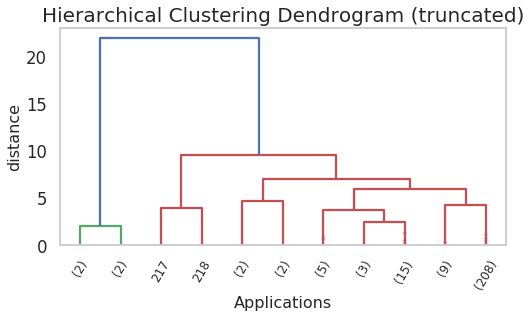

In [33]:
#randomMatrix = np.random.uniform(-10,10,size=(20,3))
#linked = linkage(randomMatrix, 'ward')
linked = linkage(c_dist, 'ward')
labels = app_names
p = len(labels)

plt.figure(figsize=(8,4))
plt.title('Hierarchical Clustering Dendrogram (truncated)', fontsize=20)
plt.xlabel('Applications', fontsize=16)
plt.ylabel('distance', fontsize=16)

# call dendrogram to get the returned dictionary 
# (plotting parameters can be ignored at this point)
R = dendrogram(
                linked,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=p,  # show only the last p merged clusters
                no_plot=True,
                )

print("values passed to leaf_label_func\nleaves : ", R["leaves"])

# create a label dictionary
temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

# First define the leaf label function.
"""def llf(id):
    if id < 11:
        return str(id)
    else:
        return '[%d %d %1.2f]' % (id, count, R[11-id,3])"""

## This version gives you your label AND the count
# temp = {R["leaves"][ii]:(labels[ii], R["ivl"][ii]) for ii in range(len(R["leaves"]))}
# def llf(xx):
#     return "{} - {}".format(*temp[xx])


dendrogram(
            linked,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=p,  # show only the last p merged clusters
            
            leaf_rotation=60.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            )
plt.show()

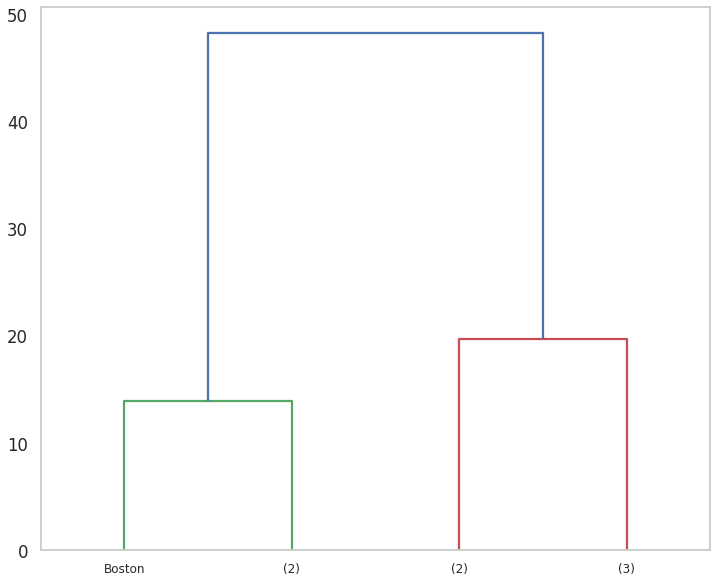

In [32]:
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

data = [[24, 16], [13, 4], [24, 11], [34, 18], [41, 
6], [35, 13], [1,2],[8,15]]
frame = pd.DataFrame(np.array(data), columns=["Rape", 
"Murder"], index=["Atlanta", "Boston", "Chicago", 
"Dallas", "Denver", "Detroit","Boston","Boston"])

Z = hierarchy.linkage(frame, 'ward')
plt.figure()
dn = hierarchy.dendrogram(Z, truncate_mode='lastp', p = 4,labels=frame.index)

In [25]:
frame

,Rape,Murder
Atlanta,24,16
Boston,13,4
Chicago,24,11
Dallas,34,18
Denver,41,6
Detroit,35,13


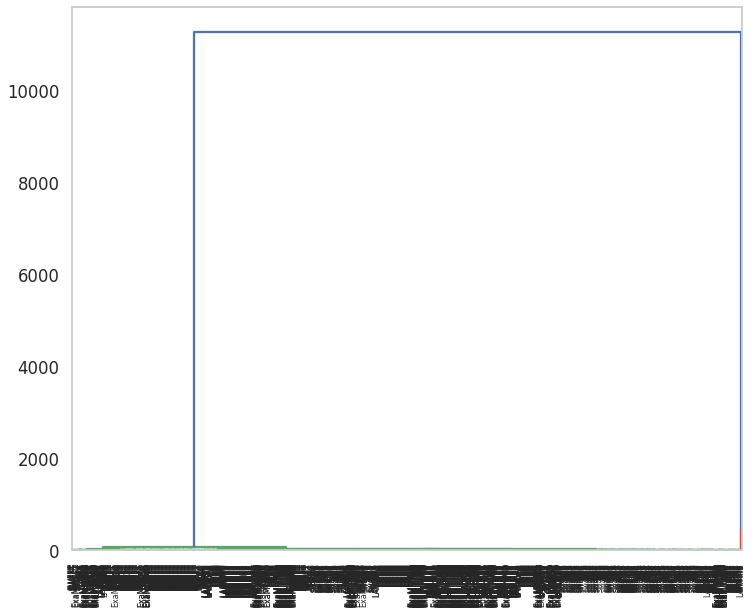

In [118]:
Z = linkage(scaled_all_normal_data, 'ward')
 
# Plot with Custom leaves
dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=scaled_all_normal_data.index)

# Show the graph
plt.show()

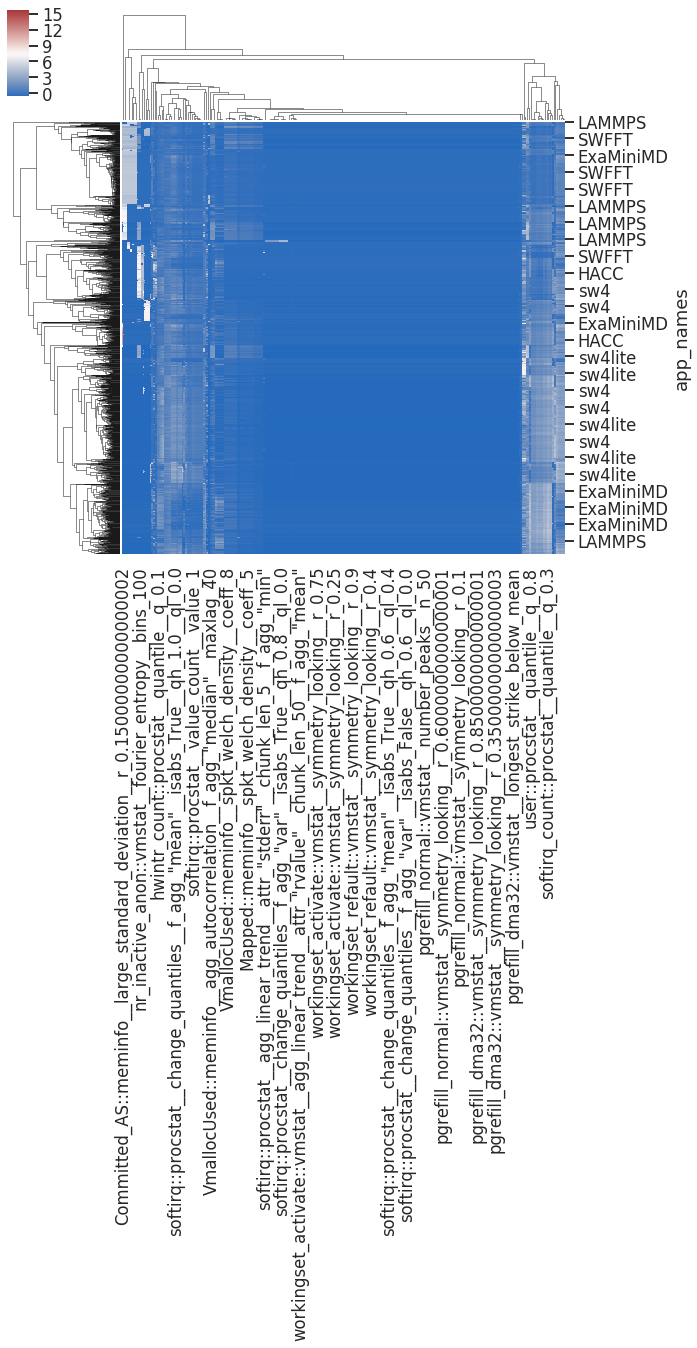

In [126]:
#iris = sns.load_dataset("iris")
#species = iris.pop("species")
#g = sns.clustermap(scaled_all_normal_data)
g = sns.clustermap(scaled_all_normal_data, z_score=0, cmap="vlag")